<a href="https://colab.research.google.com/github/sunflowerseed17/PythonDSProject/blob/main/Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Loading

In [3]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from empath import Empath
from gensim import corpora
from gensim.models import LdaModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from statsmodels.stats.multitest import multipletests
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from collections import defaultdict


import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jgber\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jgber\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Base Class
class FeatureExtractor:
    def __init__(self, documents, labels, output_folder="data/feature_extracted_data"):
        self.documents = documents
        self.labels = labels
        self.output_folder = output_folder
        os.makedirs(self.output_folder, exist_ok=True)
        

    def preprocess_text(self, text):
        """
        Tokenize, lowercase, remove stopwords, and stem.
        """
        stop_words = set(stopwords.words('english'))
        stemmer = PorterStemmer()
        tokens = word_tokenize(text.lower())
        return [stemmer.stem(word) for word in tokens if word.isalpha() and word not in stop_words]

    def save_to_csv(self, data, filename):
        """
        Save data to a CSV file.
        """
        # Construct the full file path
        if not filename.startswith(self.output_folder):
            file_path = os.path.join(self.output_folder, filename)
        else:
            file_path = filename

        # Debugging: Print the path being used
        print(f"Saving file to: {file_path}")

        # Ensure the directory exists
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        # Save the file if it doesn't already exist
        if not os.path.exists(file_path):
            data.to_csv(file_path, index=False)
            print(f"Saved to {file_path}.")
        else:
            print(f"File already exists at {file_path}.")

In [5]:
# N-Gram Feature Extractor
class NGramFeatureExtractor(FeatureExtractor):
    def __init__(self, documents, labels, output_folder="data/feature_extracted_data"):
        super().__init__(documents, labels, output_folder)
        self.vectorizer_unigram = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
        self.vectorizer_bigram = TfidfVectorizer(ngram_range=(2, 2), stop_words='english')
        self.vectorizer_combined = TfidfVectorizer(ngram_range=(1, 2), stop_words='english') 
        self.unigram_matrix = None
        self.bigram_matrix = None
        self.unigram_feature_names = None
        self.bigram_feature_names = None
        self.combined_matrix = None
        self.combined_feature_names = None

        os.makedirs(self.output_folder, exist_ok=True)

    def extract_features(self):
        """
        Extract unigram and bigram features using TF-IDF.
        """
        print("Extracting unigrams...")
        self.unigram_matrix = self.vectorizer_unigram.fit_transform(self.documents)
        self.unigram_feature_names = self.vectorizer_unigram.get_feature_names_out()
        print(f"Number of unigram features: {len(self.unigram_feature_names)}")

        print("Extracting bigrams...")
        self.bigram_matrix = self.vectorizer_bigram.fit_transform(self.documents)
        self.bigram_feature_names = self.vectorizer_bigram.get_feature_names_out()
        print(f"Number of bigram features: {len(self.bigram_feature_names)}")

        print("Extracting combined unigrams and bigrams...")
        self.combined_matrix = self.vectorizer_combined.fit_transform(self.documents)
        self.combined_feature_names = self.vectorizer_combined.get_feature_names_out()
        print(f"Number of combined unigram and bigram features: {len(self.combined_feature_names)}")

        return self.unigram_matrix, self.bigram_matrix, self.combined_matrix
    
    def save_features(self):
        """
        Save unigram and bigram features with labels as CSV files.
        """
        unigram_file = os.path.join(self.output_folder, "unigram_features_with_labels.csv")
        bigram_file = os.path.join(self.output_folder, "bigram_features_with_labels.csv")

        if not os.path.exists(unigram_file):
            unigram_df = pd.DataFrame(self.unigram_matrix.toarray(), columns=self.unigram_feature_names)
            unigram_df['label'] = self.labels
            unigram_df.to_csv(unigram_file, index=False)
            print(f"Saved unigram features to {unigram_file}.")
        else:
            print(f"Unigram features file already exists at {unigram_file}.")

        if not os.path.exists(bigram_file):
            bigram_df = pd.DataFrame(self.bigram_matrix.toarray(), columns=self.bigram_feature_names)
            bigram_df['label'] = self.labels
            bigram_df.to_csv(bigram_file, index=False)
            print(f"Saved bigram features to {bigram_file}.")
        else:
            print(f"Bigram features file already exists at {bigram_file}.")

    def get_top_features(self, feature_type="unigram", top_n=10):
        """
        Get the top N most common features for unigrams or bigrams based on TF-IDF scores.
        """
        if feature_type == "unigram":
            tfidf_sums = np.array(self.unigram_matrix.sum(axis=0)).flatten()
            feature_names = self.unigram_feature_names
        elif feature_type == "bigram":
            tfidf_sums = np.array(self.bigram_matrix.sum(axis=0)).flatten()
            feature_names = self.bigram_feature_names
        else:
            raise ValueError("Invalid feature_type. Choose 'unigram' or 'bigram'.")

        top_indices = np.argsort(tfidf_sums)[-top_n:]
        print(f"Top {top_n} Most Common {feature_type.capitalize()} Features:")
        for i in reversed(top_indices):
            print(f"{feature_names[i]}: {tfidf_sums[i]:.4f}")

    def train_model(self, feature_type="unigram"):
        """
        Train a Logistic Regression model using unigrams or bigrams.
        """
        if feature_type == "unigram":
            X = self.unigram_matrix
        elif feature_type == "bigram":
            X = self.bigram_matrix
        else:
            raise ValueError("Invalid feature_type. Choose 'unigram' or 'bigram'.")

        X_train, X_test, y_train, y_test = train_test_split(X, self.labels, test_size=0.2, random_state=42)
        print(f"Training set size: {X_train.shape}")
        print(f"Testing set size: {X_test.shape}")

        param_grid = {
            'C': [0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['liblinear']
        }
        grid_search = GridSearchCV(LogisticRegression(max_iter=500), param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        print("\nBest Hyperparameters:")
        print(grid_search.best_params_)

        classifier = grid_search.best_estimator_
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

        return classifier

    def compute_frequencies(self, feature_type="unigram"):
        """
        Compute frequencies of unigrams or bigrams for depression and non-depression posts.
        """
        if feature_type == "unigram":
            matrix = self.unigram_matrix
            feature_names = self.unigram_feature_names
        elif feature_type == "bigram":
            matrix = self.bigram_matrix
            feature_names = self.bigram_feature_names
        else:
            raise ValueError("Invalid feature_type. Choose 'unigram' or 'bigram'.")

        depression_indices = [i for i, label in enumerate(self.labels) if label == 1]
        non_depression_indices = [i for i, label in enumerate(self.labels) if label == 0]

        depression_matrix = matrix[depression_indices]
        non_depression_matrix = matrix[non_depression_indices]

        depression_sums = depression_matrix.sum(axis=0).A1
        non_depression_sums = non_depression_matrix.sum(axis=0).A1

        depression_freqs = {feature_names[i]: depression_sums[i] for i in range(len(feature_names))}
        non_depression_freqs = {feature_names[i]: non_depression_sums[i] for i in range(len(feature_names))}

        return depression_freqs, non_depression_freqs

    def get_top_n_features(self, frequencies, top_n=100):
        """
        Get the top N most frequent features from the computed frequencies.
        """
        sorted_features = sorted(frequencies.items(), key=lambda x: x[1], reverse=True)
        return sorted_features[:top_n]

    def generate_wordclouds(self):
        """
        Generate 4 word clouds:
        - Unigrams for depression
        - Bigrams for depression
        - Unigrams for non-depression
        - Bigrams for non-depression
        """
        # Compute frequencies for depression and non-depression for unigrams and bigrams
        depression_unigrams, non_depression_unigrams = self.compute_frequencies(feature_type="unigram")
        depression_bigrams, non_depression_bigrams = self.compute_frequencies(feature_type="bigram")

        # Combine word clouds into a dictionary for iteration
        wordcloud_data = {
            "Depression - Unigrams": depression_unigrams,
            "Depression - Bigrams": depression_bigrams,
            "Non-Depression - Unigrams": non_depression_unigrams,
            "Non-Depression - Bigrams": non_depression_bigrams
        }

        # Generate and display each word cloud
        for title, frequencies in wordcloud_data.items():
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencies)
            plt.figure(figsize=(10, 6))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(title, fontsize=16)
            plt.show()


In [6]:
# Empath Feature Extractor
class EmpathFeatureExtractor(FeatureExtractor):
    def __init__(self, documents, labels, selected_categories, output_folder="data/feature_extracted_data"):
        super().__init__(documents, labels, output_folder)
        self.lexicon = Empath()
        self.categories = selected_categories
        self.features = None
        self.correlation_results = None
        self.significant_results = None

    def extract_empath_features(self):
        features = []
        for doc in self.documents:
            doc_features = {}

            # Linguistic features
            for category in self.categories.get("linguistic_features", []):
                doc_features[category] = self.lexicon.analyze(doc, categories=[category])[category]

            # Psychological processes
            for subcategory, subcategories in self.categories.get("psychological_processes", {}).items():
                for category in subcategories:
                    doc_features[category] = self.lexicon.analyze(doc, categories=[category])[category]

            # Personal concerns
            for category in self.categories.get("personal_concerns", []):
                doc_features[category] = self.lexicon.analyze(doc, categories=[category])[category]

            # Time orientations
            for category in self.categories.get("time_orientations", []):
                doc_features[category] = self.lexicon.analyze(doc, categories=[category])[category]

            features.append(doc_features)

        # Convert to a DataFrame
        self.features = pd.DataFrame(features)

        # Add labels to the features DataFrame
        if len(self.features) == len(self.labels):
            self.features['label'] = self.labels
            print("Added label column to the extracted features.")
        else:
            raise ValueError("Mismatch between the number of features and labels.")

        print(f"Extracted Empath features with shape: {self.features.shape}")

    def analyze_correlation(self):
        if self.features is None:
            raise ValueError("Features must be extracted before analyzing correlations.")

        # Remove constant columns
        constant_columns = self.features.columns[self.features.nunique() == 1]
        self.features.drop(columns=constant_columns, inplace=True, errors='ignore')
        print(f"Removed constant columns: {list(constant_columns)}")

        # Validate labels
        if len(set(self.labels)) == 1:
            raise ValueError("Labels array is constant; cannot compute correlation.")

        correlations, p_values = [], []

        for column in self.features.columns.drop("label"):
            correlation, p_value = pearsonr(self.features[column], self.labels)
            correlations.append(correlation)
            p_values.append(p_value)

        correction_results = multipletests(p_values, alpha=0.05, method="fdr_bh")
        _, corrected_p_values, _, _ = correction_results

        # Create a correlation DataFrame
        self.correlation_results = pd.DataFrame({
            "Feature": self.features.columns.drop("label"),
            "Correlation": correlations,
            "P-Value": p_values,
            "Corrected P-Value": corrected_p_values
        }).sort_values(by="Correlation", key=abs, ascending=False)

    def save_features_and_results(self):
        if self.features is not None:
            feature_file = os.path.join(self.output_folder, "empath_features_with_labels.csv")
            if not os.path.exists(feature_file):
                self.features.to_csv(feature_file, index=False)
                print(f"Saved empath features with labels to {feature_file}.")
            else:
                print(f"Empath features file already exists at {feature_file}.")

        if self.correlation_results is not None:
            correlation_file = os.path.join(self.output_folder, "empath_correlation_results.csv")
            if not os.path.exists(correlation_file):
                self.correlation_results.to_csv(correlation_file, index=False)
                print(f"Saved correlation results to {correlation_file}.")
            else:
                print(f"Correlation results file already exists at {correlation_file}.")


# Empath Feature Analyzer
class EmpathFeatureAnalyzer(EmpathFeatureExtractor):
    def __init__(self, documents, labels, categories, output_folder="data/feature_extracted_data"):
        super().__init__(documents, labels, categories, output_folder)
        self.category_correlations = {}

    def group_correlations_by_subcategory(self):
        """
        Group feature correlations by subcategories and calculate the average correlation for each group.
        """
        if self.correlation_results is None:
            raise ValueError("Correlation analysis must be performed before grouping.")

        grouped_results = defaultdict(list)

        # Iterate through features, correlations, and P-values
        for feature, correlation, p_value in zip(
            self.correlation_results['Feature'],
            self.correlation_results['Correlation'],
            self.correlation_results['P-Value']
        ):
            for category, subcategories in self.categories.items():
                if isinstance(subcategories, dict):  # Handle nested subcategories
                    for subcategory, sub_features in subcategories.items():
                        if feature in sub_features:
                            grouped_results[f"{category} - {subcategory}"].append((feature, correlation, p_value))
                elif isinstance(subcategories, list):  # Handle flat categories
                    if feature in subcategories:
                        grouped_results[category].append((feature, correlation, p_value))

        # Store the top example words and average correlations
        self.category_correlations = {}
        for group, correlations in grouped_results.items():
            avg_correlation = np.mean([c[1] for c in correlations])
            sorted_features = sorted(correlations, key=lambda x: abs(x[1]), reverse=True)
            top_feature = sorted_features[0]  # Select the most correlated feature as an example
            self.category_correlations[group] = {
                "Example Word": top_feature[0],
                "Correlation": avg_correlation,
                "P-Value": top_feature[2]
            }

    def generate_summary_table(self):
        """
        Generate a summary table with categories, example words, correlations, and P-values.
        """
        if not self.category_correlations:
            raise ValueError("Category correlations must be computed before generating a summary table.")

        summary_data = []
        for category, details in self.category_correlations.items():
            summary_data.append({
                "LIWC Category": category,
                "Example Word": details["Example Word"],
                "Correlation": f"{details['Correlation']:.2f}",
                "P-Value": f"{details['P-Value']:.3f}"
            })

        summary_df = pd.DataFrame(summary_data)
        return summary_df

    def visualize_summary_table(self):
        """
        Display the summary table in the notebook.
        """
        summary_table = self.generate_summary_table()
        print(summary_table.to_string(index=False))

In [7]:
# LDA Feature Extractor
class LDAFeatureExtractor(FeatureExtractor):
    def __init__(self, documents, labels, num_topics=70, passes=15, output_folder="data/feature_extracted_data", random_state=42):
        super().__init__(documents, labels, output_folder)
        self.num_topics = num_topics
        self.passes = passes
        self.random_state = random_state
        self.dictionary = None
        self.corpus = None
        self.lda_model = None
        self.topic_distributions = None
        self.tsne_results = None

    def preprocess_documents(self):
        """
        Preprocess documents: tokenize, remove stopwords, and stem.
        """
        stop_words = set(stopwords.words('english'))
        stemmer = PorterStemmer()
        processed_docs = [
            [
                stemmer.stem(word) for word in word_tokenize(doc.lower())
                if word.isalpha() and word not in stop_words
            ]
            for doc in self.documents
        ]
        return processed_docs

    def filter_docs_by_word_count(self, processed_docs, min_documents=10):
        """
        Filter words that appear in more than 10 documents.
        """
        word_doc_count = defaultdict(int)
        for doc in processed_docs:
            unique_words = set(doc)
            for word in unique_words:
                word_doc_count[word] += 1

        filtered_docs = [
            [word for word in doc if word_doc_count[word] > min_documents]
            for doc in processed_docs
        ]
        return filtered_docs

    def train_lda(self, processed_docs):
        """
        Train the LDA model.
        """
        self.dictionary = corpora.Dictionary(processed_docs)
        self.corpus = [self.dictionary.doc2bow(doc) for doc in processed_docs]
        self.lda_model = LdaModel(
            self.corpus, num_topics=self.num_topics, id2word=self.dictionary, passes=self.passes,
            random_state=self.random_state
        )

    def extract_topic_distributions(self):
        """
        Extract topic distributions for each document.
        """
        self.topic_distributions = [
            dict(self.lda_model.get_document_topics(doc, minimum_probability=0))
            for doc in self.corpus
        ]

    def topic_distribution_to_matrix(self):
        """
        Convert topic distributions to a matrix format.
        """
        matrix = np.zeros((len(self.topic_distributions), self.num_topics))
        for i, distribution in enumerate(self.topic_distributions):
            for topic_id, prob in distribution.items():
                matrix[i, topic_id] = prob
        return matrix

    def visualize_lda(self, label_filter=None):
        """
        Visualize the LDA model with pyLDAvis, with an option to filter by depressed or non-depressed posts.

        Parameters:
        label_filter (int, optional): Filter by label. Use 1 for depressed, 0 for non-depressed. 
                                       If None, visualize all posts.
        """
        if not self.lda_model or not self.dictionary:
            raise ValueError("LDA model or dictionary not available. Train the model first.")
        
        # Filtered visualization
        if label_filter is not None:
            filtered_docs = [doc for doc, label in zip(self.documents, self.labels) if label == label_filter]
            print(f"Generating LDA visualization for {'depressed' if label_filter == 1 else 'non-depressed'} posts...")

            # Preprocess the filtered documents
            stop_words = set(stopwords.words('english'))
            stemmer = PorterStemmer()
            processed_docs = [
                [
                    stemmer.stem(word) for word in word_tokenize(doc.lower())
                    if word.isalpha() and word not in stop_words
                ]
                for doc in filtered_docs
            ]
            
            # Create a corpus for the filtered documents
            filtered_corpus = [self.dictionary.doc2bow(doc) for doc in processed_docs]
            vis = gensimvis.prepare(self.lda_model, filtered_corpus, self.dictionary)
        else:
            # Visualization for all posts
            print("Generating LDA visualization for all posts...")
            vis = gensimvis.prepare(self.lda_model, self.corpus, self.dictionary)

        # Ensure pyLDAvis works in the notebook
        pyLDAvis.enable_notebook()  # Enable visualization in Jupyter Notebook

        # Display visualization
        return pyLDAvis.display(vis)


    def save_features(self):
        """
        Save LDA topic distributions with labels to a CSV file.
        """
        if not self.topic_distributions:
            raise ValueError("Topic distributions are not extracted.")

        # Prepare the LDA features data
        topic_matrix = self.topic_distribution_to_matrix()
        labels_array = np.array(self.labels)
        lda_features_df = pd.DataFrame(topic_matrix)
        lda_features_df['label'] = labels_array

        # Define the filename
        lda_features_file = "lda_topic_distributions_with_labels.csv"

        # Call the base class method for saving
        self.save_to_csv(lda_features_df, lda_features_file)
        
    def run_pipeline(self):
        """
        Complete LDA pipeline: preprocess, train, extract, visualize, and save.
        """
        print("Preprocessing documents...")
        processed_docs = self.preprocess_documents()
        filtered_docs = self.filter_docs_by_word_count(processed_docs)

        print("Training LDA model...")
        self.train_lda(filtered_docs)

        print("Extracting topic distributions...")
        self.extract_topic_distributions()

        print("Saving features...")
        self.save_features()

        print("LDA pipeline complete.")

In [8]:
# Loading data
if __name__ == "__main__":
    # Load documents and labels
    folders = {
        "depression": {"path": "data/preprocessed_posts/depression", "label": 1},
        "standard": {"path": "data/preprocessed_posts/standard", "label": 0},
    }
    documents, labels = [], []
    for category, data in folders.items():
        for file_name in os.listdir(data["path"]):
            file_path = os.path.join(data["path"], file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                documents.append(file.read())
                labels.append(data["label"])
    print(f"Loaded {len(documents)} documents.")
    print(f"Labels: {set(labels)}")


Loaded 1890 documents.
Labels: {0, 1}


# N-Gram Extraction

Extracting unigrams...
Number of unigram features: 11693
Extracting bigrams...
Number of bigram features: 68385
Extracting combined unigrams and bigrams...
Number of combined unigram and bigram features: 80078
Saved unigram features to data/feature_extracted_data\unigram_features_with_labels.csv.
Saved bigram features to data/feature_extracted_data\bigram_features_with_labels.csv.

Top Unigram Features:
Top 10 Most Common Unigram Features:
like: 53.9444
feel: 51.8218
en: 48.5996
work: 37.9773
team: 37.8026
want: 35.7957
descript: 34.7429
time: 34.4586
je: 34.3917
og: 33.3214

Top Bigram Features:
Top 10 Most Common Bigram Features:
appli http: 24.2725
learn appli: 24.2725
new zealand: 19.2218
feel like: 17.2643
descript job: 11.8463
singapor descript: 10.7059
job descript: 10.5532
zealand descript: 10.0209
netherland descript: 8.5347
state america: 7.6747

Training a model with unigram features...
Training set size: (1512, 11693)
Testing set size: (378, 11693)

Best Hyperparameters:
{'

C:\Users\jgber\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\jgber\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\jgber\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


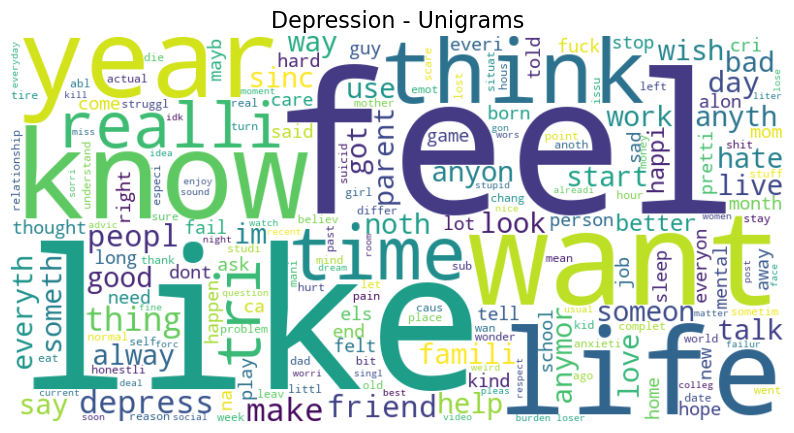

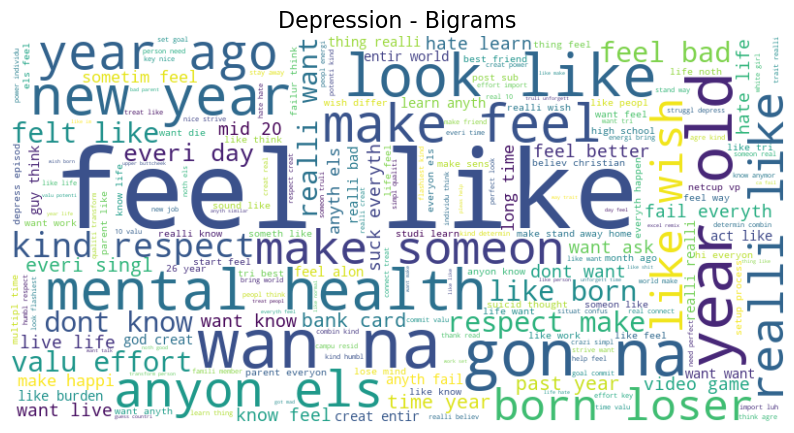

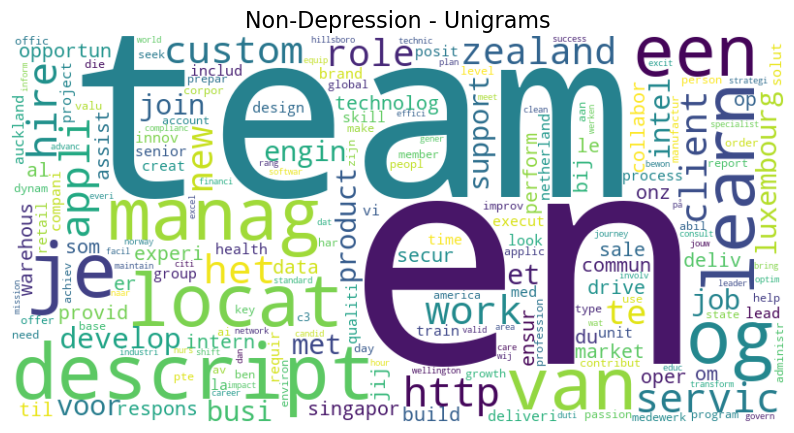

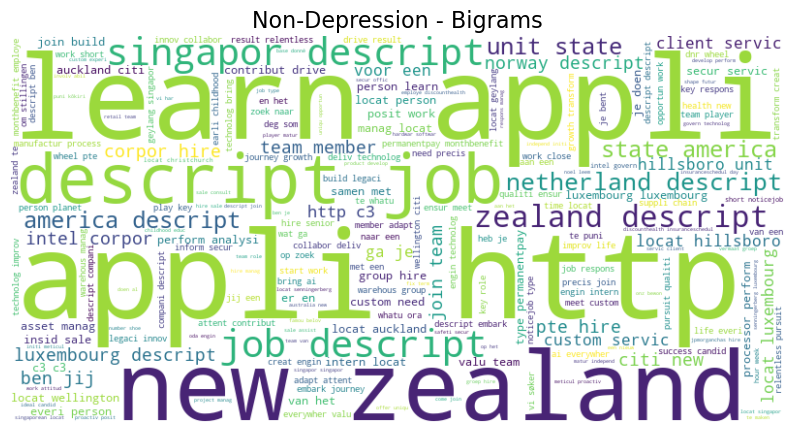

In [9]:
# Initialize, extract, save, analyze, train and generate word clouds.
# Initialize the n-gram extractor
ngram_extractor = NGramFeatureExtractor(documents, labels)

# Extract features
ngram_extractor.extract_features()

# Save features
ngram_extractor.save_features()

# Analyze top features
print("\nTop Unigram Features:")
ngram_extractor.get_top_features(feature_type="unigram", top_n=10)
print("\nTop Bigram Features:")
ngram_extractor.get_top_features(feature_type="bigram", top_n=10)


# Train a model
print("\nTraining a model with unigram features...")
classifier = ngram_extractor.train_model(feature_type="unigram")

# Generate word clouds
print("\nGenerating Word Clouds...")
ngram_extractor.generate_wordclouds()

# Empath Extraction

In [10]:
# Categories to focus on based on the origin paper. 
# The categories are divided into linguistic features, psychological processes, personal concerns, and time orientations.
# Since we cannot use the LIWC tool, we will use the Empath tool and define similar categorical features. 

selected_categories = {
    "linguistic_features": [
        "articles", "auxiliary_verbs", "adverbs", "conjunctions", 
        "personal_pronouns", "impersonal_pronouns", "negations", 
        "prepositions", "verbs", "nouns", "adjectives", 
        "comparatives", "superlatives", "modifiers", "function_words", 
        "filler_words", "verb_tense", "slang", "jargon", 
        "formal_language", "casual_language", "exclamations", 
        "contractions", "word_complexity", "sentiment_words"
    ],
        "psychological_processes": {
        "affective": [
            "positive_emotion", "negative_emotion", "joy", "anger", 
            "sadness", "anxiety", "fear", "disgust", "love", 
            "hope", "trust", "excitement", "anticipation", 
            "relief", "sympathy", "gratitude", "shame", 
            "guilt", "envy", "pride", "contentment", "confusion",
            "boredom", "embarrassment", "longing", "nostalgia", 
            "embarrassment", "frustration", "surprise", "melancholy"
        ],
        "biological": [
            "body", "health", "illness", "pain", "hygiene", 
            "fitness", "exercise", "nutrition", "ingestion", 
            "physical_state", "medicine", "sleep", "sexual", 
            "aging", "disease", "injury", "hospital", "recovery", 
            "dieting", "mental_health", "drug_use", "headache", 
            "fatigue", "hormones", "appetite"
        ],
        "social": [
            "family", "friends", "relationships", "group_behavior", 
            "teamwork", "social_media", "communication", "community", 
            "peer_pressure", "leadership", "parenting", "mentorship", 
            "marriage", "divorce", "gender_roles", "social_identity", 
            "cultural_rituals", "networking", "altruism", "conflict", 
            "social_support", "dominance", "affiliation", "intimacy", 
            "supportiveness", "competition", "conflict_resolution", 
            "collaboration", "in-group", "out-group", "prejudice"
        ],
        "cognitive": [
            "certainty", "doubt", "insight", "cause", "discrepancy", 
            "problem_solving", "creativity", "self_reflection", "planning", 
            "memory", "perception", "attention", "reasoning", "thought_process", 
            "decision_making", "confusion", "learning", "metacognition", "adaptability", 
            "focus", "perspective", "problem_analysis", "evaluation", "interpretation",
            "logic", "intelligence", "rational_thought", "intuition", "conceptualization"
        ],
        "drives": [
            "achievement", "dominance", "affiliation", "control", 
            "self-esteem", "autonomy", "self-assertion", "power", 
            "ambition", "conformity", "subordination", "dependence", 
            "submission", "accomplishment", "independence", "order", 
            "control_seeking", "status", "prosocial_behavior"
        ],
        "spiritual": [
            "spirituality", "faith", "beliefs", "sacred", "religion", 
            "prayer", "meditation", "afterlife", "soul", "divine", 
            "god", "higher_power", "inspiration", "transcendence", 
            "morality", "ethics", "rituals", "holiness", "mindfulness"
        ]
    },
    "personal_concerns": [
        "work", "money", "wealth", "shopping", "career", "travel", 
        "home", "school", "education", "violence", "death", 
        "retirement", "spirituality", "family_life", "hobbies", 
        "volunteering", "pets", "entertainment", "parenting", 
        "sports", "adventure", "politics", "environment", 
        "safety", "technology", "materialism", "status", 
        "self_improvement", "learning", "self_growth", "happiness", 
        "life_purpose", "work_life_balance", "stress", "coping", 
        "job_satisfaction", "ambition", "legacy", "job_search", 
        "unemployment", "retirement_plans", "mental_health", "dating", 
        "romantic_relationships", "divorce", "life_stressors", "transitions"
    ],
    "time_orientations": [
        "present", "past", "future", "morning", 
        "afternoon", "evening", "day", "night", 
        "weekdays", "weekends", "seasons", "holidays", 
        "lifespan", "long_term", "short_term", 
        "routine", "historical", "epoch", "momentary", 
        "timeliness", "timelessness", "urgency", 
        "progression", "nostalgia", "anticipation"
    ]
}
%store selected_categories

Stored 'selected_categories' (dict)


In [11]:
# Initialize Empath Feature Extractor
empath_extractor = EmpathFeatureExtractor(documents, labels, selected_categories)

# Extract features
empath_extractor.extract_empath_features()

# Analyze correlations
empath_extractor.analyze_correlation()

# Save features and results
empath_extractor.save_features_and_results()

Added label column to the extracted features.
Extracted Empath features with shape: (1890, 238)
Removed constant columns: ['articles', 'auxiliary_verbs', 'adverbs', 'conjunctions', 'personal_pronouns', 'impersonal_pronouns', 'negations', 'prepositions', 'verbs', 'nouns', 'adjectives', 'comparatives', 'superlatives', 'modifiers', 'function_words', 'filler_words', 'verb_tense', 'slang', 'jargon', 'formal_language', 'casual_language', 'exclamations', 'contractions', 'word_complexity', 'sentiment_words', 'anxiety', 'hope', 'excitement', 'relief', 'gratitude', 'guilt', 'boredom', 'embarrassment', 'longing', 'nostalgia', 'frustration', 'melancholy', 'illness', 'fitness', 'nutrition', 'ingestion', 'physical_state', 'medicine', 'aging', 'disease', 'hospital', 'recovery', 'dieting', 'mental_health', 'drug_use', 'headache', 'fatigue', 'hormones', 'appetite', 'relationships', 'group_behavior', 'teamwork', 'community', 'peer_pressure', 'leadership', 'parenting', 'mentorship', 'marriage', 'divorce'

# LDA (Latent Dirichlet Allocation) Extraction

In [12]:
# Initializing LDA Feature Extractor
lda_extractor = LDAFeatureExtractor(documents, labels)
lda_extractor.run_pipeline()

Preprocessing documents...
Training LDA model...
Extracting topic distributions...
Saving features...
Saving file to: data/feature_extracted_data\lda_topic_distributions_with_labels.csv
Saved to data/feature_extracted_data\lda_topic_distributions_with_labels.csv.
LDA pipeline complete.


In [13]:
# Visualising depression
lda_extractor.visualize_lda(label_filter=1)

Generating LDA visualization for depressed posts...


In [14]:
# Visualising non-depression
lda_extractor.visualize_lda(label_filter=0)

Generating LDA visualization for non-depressed posts...
